# Nearest Shrunken Centroids (NSC) Notebook

This notebook illustrates the use of the nearest shrunken centroids classifier on the SRBC dataset. We show that this simple classifier has improved properties over QDA and is more interpretable, as a consequence of using only a few attributes for prediction.

First, we load the required packages.

In [20]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestCentroid
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd

# We ignore warnings (they arise in QDA due to the high dimensionality of the data)

#import warnings
#warnings.filterwarnings("ignore")

## Loading the Data

We load the data from a CSV file using pandas. The dataset considered is 'Simple Round Blue Cell Tumors' (SRBCT) dataset from the reference: Khan, J., Wei, J. S., Ringnér, M., Saal, L. H., Ladanyi, M., Westermann, F., … Meltzer, P. S. (2001). Classification and diagnostic prediction of cancers using gene expression profiling and artificial neural networks. Nature Medicine, 7(6), 673–679. http://doi.org/10.1038/89044. This dataset has a training and a testing set, each containing 64 and 20 instances, respectively. The number of attributes is 2308, corresponding to different gene expression profiles. The number of classes is 4, corresponding to different tumors:  neuroblastoma (NB), rhabdomyosarcoma (RMS), non-Hodgkin lymphoma (NHL) and the Ewing family of tumors (EWS).

In [21]:
dataTrain = pd.read_csv('srbct_train.csv')
X_train = dataTrain.values[ :, 0 : (dataTrain.shape[ 1 ] - 1) ].astype(float)
y_train = (dataTrain.values[ :, dataTrain.shape[ 1 ] - 1 ]).astype(int)

dataTest = pd.read_csv('srbct_test.csv')
X_test = dataTest.values[ :, 0 : (dataTest.shape[ 1 ] - 1) ].astype(float)
y_test = (dataTest.values[ :, dataTest.shape[ 1 ] - 1 ]).astype(int)


In [22]:
print(X_train.shape)
print(X_test.shape)

(64, 2308)
(20, 2308)


## Data Standardization

We standardize the data to have zero mean and unit standard deviation.

In [23]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

We check the standardization process.

In [24]:
print(np.var(X_train[:,0]))
print(np.var(X_train[:,1]))
print(np.var(X_train_scaled[:,0]))
print(np.var(X_train_scaled[:,1]))

0.7919269083764648
0.12906755295898437
1.0
0.9999999999999999


## Evaluating the Performance of NSC and QDA on the Test set


Before training the classifiers NSC and QDA we will have to choose a good value for the corresponding regularization hyper-parameter. In this case, the parameter of NSC is the shrink_threshold taking values in $[0,+\infty]$. In the case of QDA, we have to choose the value for $\lambda$ (reg_param), which regularizes the covariance matrix estimate $(1-\lambda)\cdot \mathbf{\Sigma} + \lambda \cdot \mathbf{I}$. 

### Defining the Pipeline of Data Transformation and Estimation

We create a Pipeline for training the classifier in the inner cross validation procedure. If required, in this pipeline we may also consider extra data transformations such as additional standardization steps for each partition of the data. We omit this step here, since we have already standardized the training data.

In [25]:
pipeline_qda = Pipeline([ ('qda', QuadraticDiscriminantAnalysis()) ])
pipeline_nsc = Pipeline([ ('nsc', NearestCentroid()) ])

### Indicating Potential Values for the Hyperparameters


We specify values for the hyperparameters of the classifier. In this case, the values of lambda. We consider 20 values in the interval $[0,1]$. In the case of NSC we consider 20 values between 0 and 8.

In [26]:
reg_param_values = np.linspace(0, 1, 20).tolist()
param_grid_qda = { 'qda__reg_param': reg_param_values }

shrinkage_param_values = np.linspace(1e-6, 8, 20).tolist()
param_grid_nsc = {'nsc__shrink_threshold': shrinkage_param_values}

### Evaluating the Performance for each Value of the Hyperparameters

We use stratified 10 fold cross-validation, to estimate the performance of the classifier. We use prediction accuracy as the evaluation metric. Other metrics can be considered as well. We will consider 10 splits of the data, corresponding to 10-fold-cv.

In [27]:
skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0)
gridcv_qda = GridSearchCV(pipeline_qda, cv=skfold, n_jobs=1, param_grid=param_grid_qda, \
    scoring=make_scorer(accuracy_score))
result_qda = gridcv_qda.fit(X_train_scaled, y_train)

gridcv_nsc = GridSearchCV(pipeline_nsc, cv=skfold, n_jobs=1, param_grid=param_grid_nsc, \
    scoring=make_scorer(accuracy_score))
result_nsc = gridcv_nsc.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/pyt

### Obtaining the Results


We get the mean accuracy and the corresponding standard deviation across data splits.

In [28]:
accuracies_qda = gridcv_qda.cv_results_['mean_test_score']
std_accuracies_qda = gridcv_qda.cv_results_['std_test_score']

accuracies_nsc = gridcv_nsc.cv_results_['mean_test_score']
std_accuracies_nsc = gridcv_nsc.cv_results_['std_test_score']

We also obtain the accuracy on the test set and the training set for comparison purposes.

In [29]:
test_accuracies_qda = np.ones(len(reg_param_values))
train_accuracies_qda = np.ones(len(reg_param_values))

test_accuracies_nsc = np.ones(len(shrinkage_param_values))
train_accuracies_nsc = np.ones(len(shrinkage_param_values))

# First QDA

for i in range(len(reg_param_values)):
    qda = QuadraticDiscriminantAnalysis(reg_param = reg_param_values[ i ])
    qda.fit(X_train_scaled, y_train)
    test_accuracies_qda[ i ] = accuracy_score(qda.predict(X_test_scaled), y_test)
    train_accuracies_qda[ i ] = accuracy_score(qda.predict(X_train_scaled), y_train)

# Next NSC

for i in range(len(shrinkage_param_values)):
    nsc = NearestCentroid(shrink_threshold = shrinkage_param_values[ i ])
    nsc.fit(X_train_scaled, y_train)
    test_accuracies_nsc[ i ] = accuracy_score(nsc.predict(X_test_scaled), y_test)
    train_accuracies_nsc[ i ] = accuracy_score(nsc.predict(X_train_scaled), y_train)

    

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/disc

In [30]:
test_accuracies_qda


array([0.35, 0.4 , 0.3 , 0.25, 0.25, 0.25, 0.25, 0.2 , 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.05])

In [31]:
train_accuracies_qda

array([1.      , 0.140625, 0.125   , 0.125   , 0.125   , 0.125   ,
       0.125   , 0.125   , 0.125   , 0.125   , 0.125   , 0.109375,
       0.078125, 0.0625  , 0.015625, 0.015625, 0.015625, 0.      ,
       0.      , 0.      ])

### Plotting the Results


For a better visualization of the average results, we plot them, showing also the corresponding standard deviation estimate.

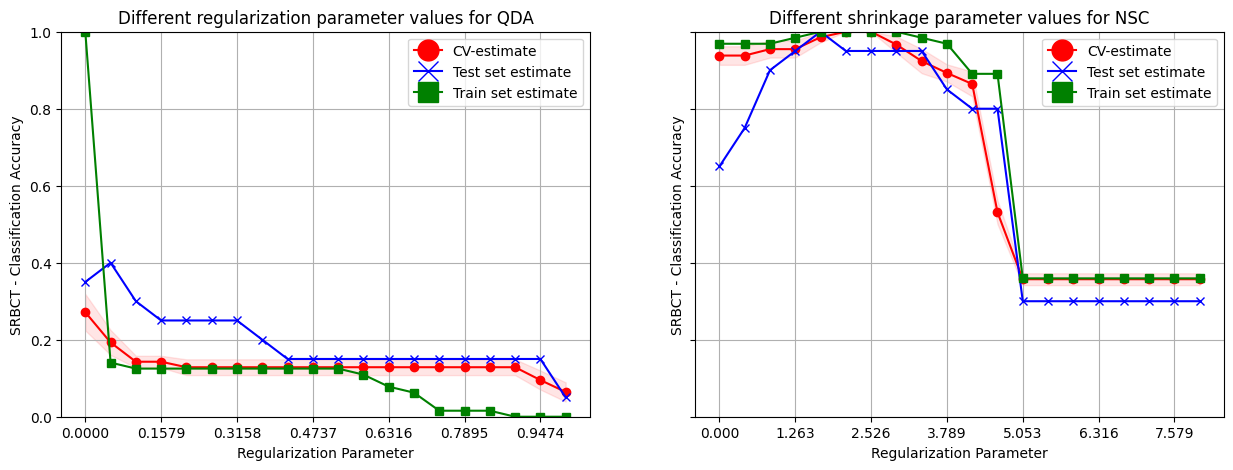

In [32]:
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 5))

# First QDA

line1, = axarr[ 0 ].plot(reg_param_values, accuracies_qda, 'o-', color="r")
line2, = axarr[ 0 ].plot(reg_param_values, test_accuracies_qda, 'x-', color="b")
line3, = axarr[ 0 ].plot(reg_param_values, train_accuracies_qda, 's-', color="g")

axarr[ 0 ].fill_between(reg_param_values, accuracies_qda - std_accuracies_qda / np.sqrt(10), \
    accuracies_qda + std_accuracies_qda / np.sqrt(10), alpha=0.1, color="r")
axarr[ 0 ].grid()
axarr[ 0 ].set_title("Different regularization parameter values for QDA")
axarr[ 0 ].set_xlabel('Regularization Parameter')
axarr[ 0 ].set_xticks(reg_param_values[ 0::3 ])
axarr[ 0 ].set_ylabel('SRBCT - Classification Accuracy')
axarr[ 0 ].set_ylim((0.0, 1.0))
legend_handles = [ mlines.Line2D([], [], color='r', marker='o', \
                          markersize=15, label='CV-estimate'), \
                mlines.Line2D([], [], color='b', marker='x', \
                          markersize=15, label='Test set estimate'), \
                 mlines.Line2D([], [], color='g', marker='s', \
                          markersize=15, label='Train set estimate')]
axarr[ 0 ].legend(handles=legend_handles, loc = 1)

# Now NSC

line1, = axarr[ 1 ].plot(shrinkage_param_values, accuracies_nsc, 'o-', color="r")
line2, = axarr[ 1 ].plot(shrinkage_param_values, test_accuracies_nsc, 'x-', color="b")
line3, = axarr[ 1 ].plot(shrinkage_param_values, train_accuracies_nsc, 's-', color="g")

axarr[ 1 ].fill_between(shrinkage_param_values, accuracies_nsc - std_accuracies_nsc / np.sqrt(10), \
    accuracies_nsc + std_accuracies_nsc / np.sqrt(10), alpha=0.1, color="r")
axarr[ 1 ].grid()
axarr[ 1 ].set_title("Different shrinkage parameter values for NSC")
axarr[ 1 ].set_xlabel('Regularization Parameter')
axarr[ 1 ].set_xticks(shrinkage_param_values[ 0::3 ])
axarr[ 1 ].set_ylabel('SRBCT - Classification Accuracy')
axarr[ 1 ].set_ylim((0.0, 1.0))
legend_handles = [ mlines.Line2D([], [], color='r', marker='o', \
                          markersize=15, label='CV-estimate'), \
                mlines.Line2D([], [], color='b', marker='x', \
                          markersize=15, label='Test set estimate'), \
                mlines.Line2D([], [], color='g', marker='s', \
                          markersize=15, label='Train set estimate')]
axarr[ 1 ].legend(handles=legend_handles, loc = 1)

plt.show()

We observe that QDA performs very poorly. This is a consequence of the high dimensionality of this dataset (2308 attributes) and the difficultiy of estimating accurate covariance matrices. NSC performs much better due to the reduced number of parameters and the feature selection properties of this classifier. When the shrinkage parameter is equal to zero, NSC is equivalent to DLDA.

We now find the best performing shrinkage parameter for NSC.

In [33]:
print(shrinkage_param_values[ np.argmax(accuracies_nsc) ])

2.1052638947368423


### Fitting the Final Model and Estimating Its Performance


For this step, we use the whole training data available and the best observed parameter value. We focus on NSC and discart QDA due to the poor performance shown. 

In [34]:
nsc = NearestCentroid(shrink_threshold = shrinkage_param_values[ np.argmax(accuracies_nsc) ])
nsc.fit(X_train_scaled, y_train)
y_pred = nsc.predict(X_test_scaled)
conf = confusion_matrix(y_test, y_pred)

In [35]:
print(conf)
print('\nPredicion accuracy is: %f' % (np.sum(np.diag(conf)) / np.sum(conf)))

[[5 0 0 1]
 [0 3 0 0]
 [0 0 6 0]
 [0 0 0 5]]

Predicion accuracy is: 0.950000


## Plotting the Centroids and the Relevant Features

We will extract information about the means associated to each class. Remember that they have the form: $$\mu_{kj} = m_j + \Delta_{kj}\,,$$ where $\Delta_{kj}$ is the shrunken component. If equal to zero, feature $j$ will not be relevant for classification.

We first train a classifier with no shrinkage at all, and then compare results with the optimal one found previously.

In [36]:
nsc_no_shrink = NearestCentroid(shrink_threshold = None)
nsc_no_shrink.fit(X_train_scaled, y_train)

NearestCentroid()

Now, we plot the centroids.

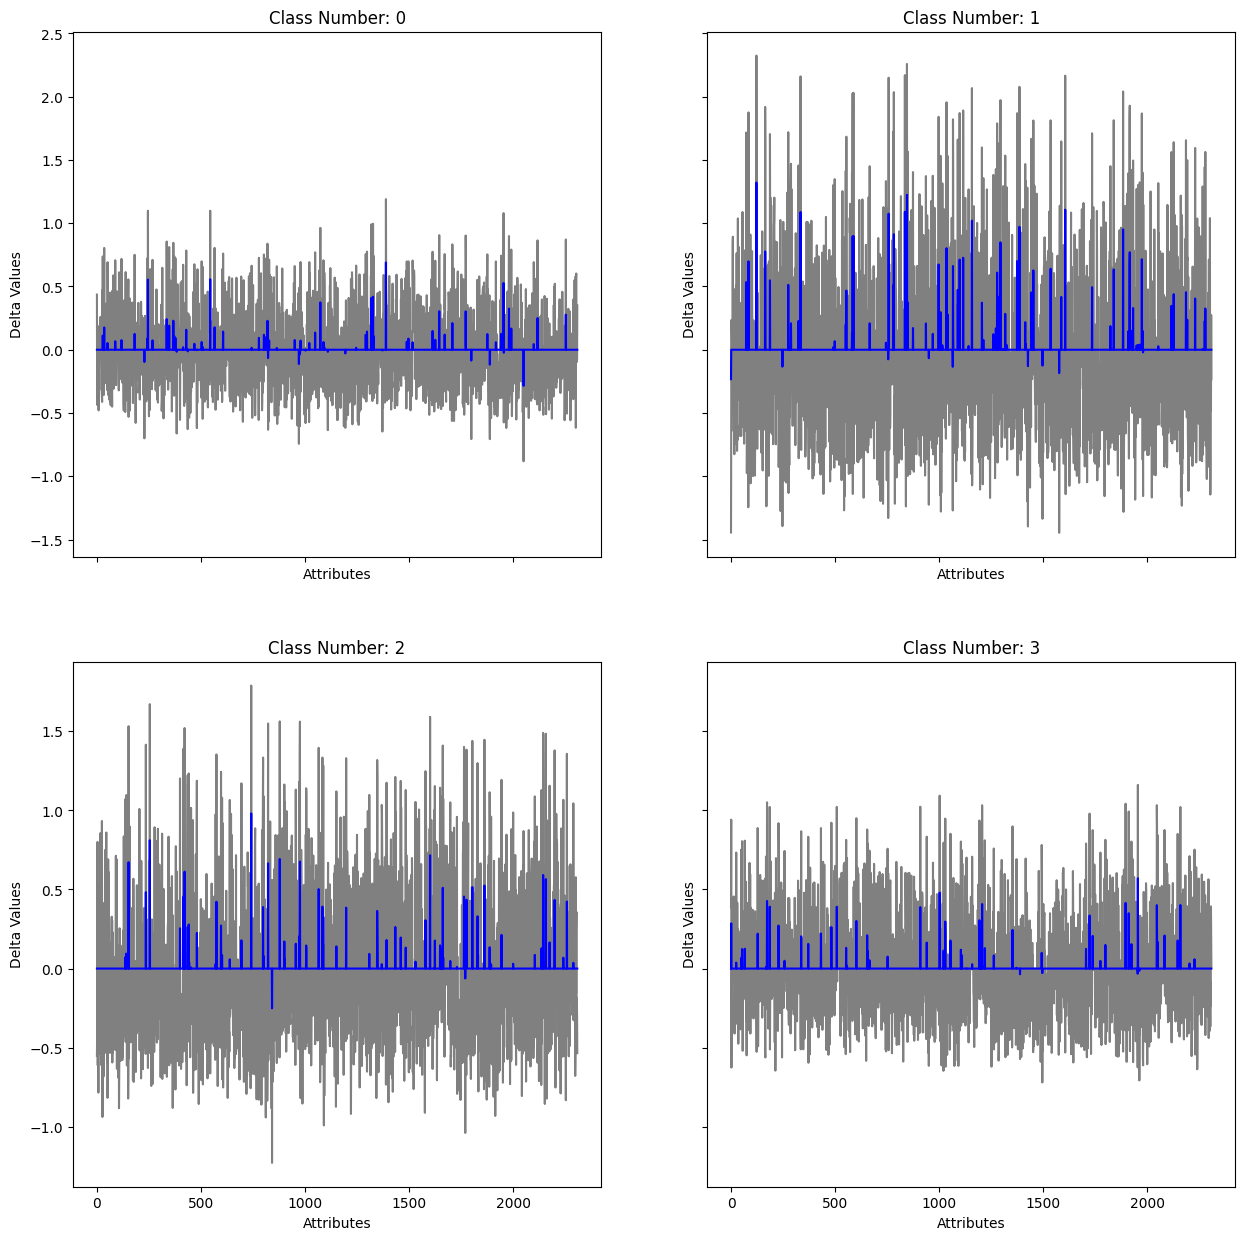

In [37]:
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(15, 15))

for i in range(2):
    for j in range(2):
        
        class_num = i * 2 + j
        
        axarr[i,j].plot(np.arange(0, X_train.shape[ 1 ]), \
            nsc_no_shrink.centroids_[ class_num, ], '-', color="gray")
        axarr[i,j].plot(np.arange(0, X_train.shape[ 1 ]), \
            nsc.centroids_[ class_num, ], '-', color="blue")
        axarr[i,j].set_title('Class Number: ' + str(class_num))
        axarr[i,j].set_xlabel('Attributes')
        axarr[i,j].set_ylabel('Delta Values')

plt.show()

We observe that when there is no shrinkage, $\Delta_{kj}$ is in general different from zero, as expected. When there is some shrinkage most of the $\Delta_{kj}$ values are driven to zero, meanining that the corresponding features will not be relevant for classification. 

### Counting the Number of Relevant Attributes

We find how many attributes are actually relevant for classification. Those are those attributes $j$ that satisfy that $\Delta_{kj} \neq 0\,, \forall k$.

In [38]:
# We use 1e-6 instead of 0 because some delta values are very small, but not zero. 

np.sum(np.any(np.abs(nsc.centroids_) > 1e-6, axis = 0))

306

We can observe that only 306 attributes from the total of 2308 are actually used for classification.